In [ ]:
!apt-get -qq update
!apt-get -qq install -y octave gnuplot octave-signal octave-control > /dev/null
!python -m pip -q install oct2py scipy matplotlib pillow

from oct2py import Oct2Py, Oct2PyError
import numpy as np, matplotlib.pyplot as plt, textwrap
from scipy.io import savemat, loadmat
from PIL import Image

oc = Oct2Py()
print("Octave version:", oc.eval("version"))

def show_png(path, title=None):
    img = Image.open(path)
    plt.figure(figsize=(5,4)); plt.imshow(img); plt.axis("off")
    if title: plt.title(title)
    plt.show()

In [ ]:
print("\n--- Basic eval ---")
print(oc.eval("A = magic(4); A"))
print("eig(A) diag:", oc.eval("[V,D]=eig(A); diag(D)'"))
print("sin(pi/4):", oc.eval("sin(pi/4)"))

print("\n--- NumPy exchange ---")
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x) + 0.1*np.random.randn(x.size)
y_filt = oc.feval("conv", y, np.ones(5)/5.0, "same")
print("y_filt shape:", np.asarray(y_filt).shape)

print("\n--- Cells & Structs ---")
cells = ["hello", 42, [1,2,3]]
oc.push("C", cells)
oc.eval("s = struct('name','Ada','score',99,'tags',{C});")
s = oc.pull("s")
print("Struct from Octave -> Python:", s)

In [ ]:
print("\n--- Writing and calling .m files ---")
gd_code = r"""
function [w, hist] = gradient_descent(X, y, alpha, iters)
  % X: (n,m), y: (n,1). Adds bias; returns weights and loss history.
  if size(X,2) == 0, error('X must be 2D'); end
  n = rows(X);
  Xb = [ones(n,1), X];
  m = columns(Xb);
  w = zeros(m,1);
  hist = zeros(iters,1);
  for t=1:iters
    yhat = Xb*w;
    g = (Xb'*(yhat - y))/n;
    w = w - alpha * g;
    hist(t) = (sum((yhat - y).^2)/(2*n));
  endfor
endfunction
"""
with open("gradient_descent.m","w") as f: f.write(textwrap.dedent(gd_code))

np.random.seed(0)
X = np.random.randn(200, 3)
true_w = np.array([2.0, -1.0, 0.5, 3.0])
y = true_w[0] + X @ true_w[1:] + 0.3*np.random.randn(200)
w_est, hist = oc.gradient_descent(X, y.reshape(-1,1), 0.1, 100, nout=2)
print("Estimated w:", np.ravel(w_est))
print("Final loss:", float(np.ravel(hist)[-1]))

print("\n--- Octave plotting -> PNG -> Python display ---")
oc.eval("x = linspace(0,2*pi,400); y = sin(2*x) .* exp(-0.2*x);")
oc.eval("figure('visible','off'); plot(x,y,'linewidth',2); grid on; title('Damped Sine (Octave)');")
plot_path = "/content/oct_plot.png"
oc.eval(f"print('{plot_path}','-dpng'); close all;")
show_png(plot_path, title="Octave-generated Plot")

In [ ]:
print("\n--- Packages (signal/control) ---")
signal_ok = True
try:
    oc.eval("pkg load signal; pkg load control;")
    print("Loaded: signal, control")
except Oct2PyError as e:
    signal_ok = False
    print("Could not load signal/control, skipping package demo.\nReason:", str(e).splitlines()[0])

if signal_ok:
    oc.push("t", np.linspace(0,1,800))
    oc.eval("x = sin(2*pi*5*t) + 0.5*sin(2*pi*40*t);")
    oc.eval("[b,a] = butter(4, 10/(800/2)); xf = filtfilt(b,a,x);")
    xf = oc.pull("xf")
    plt.figure(); plt.plot(xf); plt.title("Octave signal package: filtered"); plt.show()

print("\n--- Function handles ---")
oc.eval("""
f = @(z) z.^2 + 3*z + 2;
vals = feval(f, [0 1 2 3]);
""")
vals = oc.pull("vals")
print("f([0,1,2,3]) =", np.ravel(vals))

quadfun_code = r"""
function y = quadfun(z)
  y = z.^2 + 3*z + 2;
end
"""
with open("quadfun.m","w") as f: f.write(textwrap.dedent(quadfun_code))
vals2 = oc.quadfun(np.array([0,1,2,3], dtype=float))
print("quadfun([0,1,2,3]) =", np.ravel(vals2))

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
ans = 6.4.0
Octave version: 6.4.0

--- Basic eval ---
A =

   16    2    3   13
    5   11   10    8
    9    7    6   12
    4   14   15    1

None
ans =

   3.4000e+01   8.9443e+00  -8.9443e+00   2.0576e-15

eig(A) diag: [[ 3.40000000e+01  8.94427191e+00 -8.94427191e+00  2.05764328e-15]]
ans = 0.7071
sin(pi/4): 0.7071067811865475

--- NumPy exchange ---
y_filt shape: (1, 100)

--- Cells & Structs ---
Struct from Octave -> Python: {'name': 'Ada', 'score': 99.0, 'tags': Cell([['hello', 42.0, array([[1., 2., 3.]])]])}

--- Writing and calling .m files ---
Estimated w: [ 1.95494178 -0.99214262  0.45687838  2.97437268]
Final loss: 0.04135165651803543

--- Octave plotting -> PNG -> Python display ---


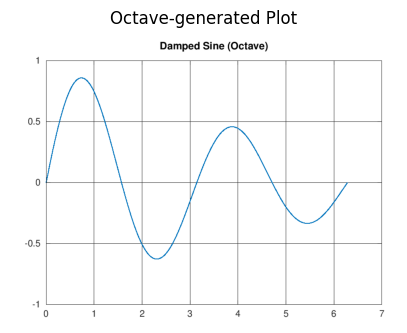


--- Packages (signal/control) ---
Loaded: signal, control


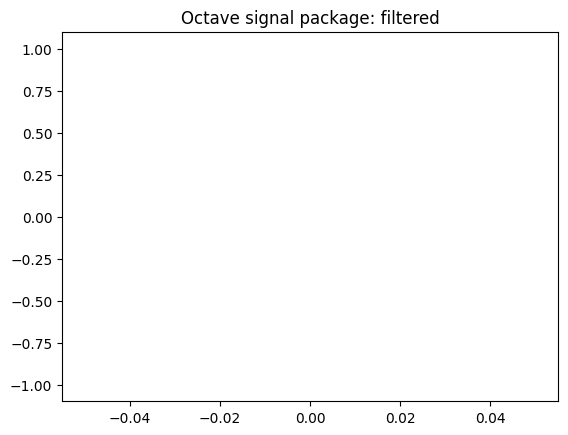


--- Function handles ---
f([0,1,2,3]) = [ 2.  6. 12. 20.]
quadfun([0,1,2,3]) = [ 2.  6. 12. 20.]

--- .mat I/O ---
Keys from Octave-saved mat: ['__header__', '__version__', '__globals__', 'A2', 'label']

--- Error handling ---
Caught Octave error as Python exception:
 Octave evaluation error:

--- Simple Octave benchmark ---
Vectorized sum: 0.0062s | Loop sum: 5.1294s

--- Multi-file pipeline ---
mini_pipeline -> keys: ['rms', 'peak', 'env']
RMS ~ 0.7064386470755233 | Peak ~ 1.120639650248206 | env head: [1.02042175 0.94322802 0.94432314 0.92721811 0.9351104 ]

All sections executed. You are now running MATLAB/Octave code from Python!


In [5]:
print("\n--- .mat I/O ---")
data_py = {"A": np.arange(9).reshape(3,3), "label": "demo"}
savemat("demo.mat", data_py)
oc.eval("load('demo.mat'); A2 = A + 1;")
oc.eval("save('-mat','demo_from_octave.mat','A2','label');")
back = loadmat("demo_from_octave.mat")
print("Keys from Octave-saved mat:", list(back.keys()))

print("\n--- Error handling ---")
try:
    oc.eval("no_such_function(1,2,3);")
except Oct2PyError as e:
    print("Caught Octave error as Python exception:\n", str(e).splitlines()[0])

print("\n--- Simple Octave benchmark ---")
oc.eval("N = 2e6; a = rand(N,1);")

oc.eval("tic; s1 = sum(a); tv = toc;")
t_vec = float(oc.pull("tv"))

oc.eval("tic; s2 = 0; for i=1:length(a), s2 += a(i); end; tl = toc;")
t_loop = float(oc.pull("tl"))

print(f"Vectorized sum: {t_vec:.4f}s | Loop sum: {t_loop:.4f}s")

print("\n--- Multi-file pipeline ---")
pipeline_m = r"""
function out = mini_pipeline(x, fs)
  try, pkg load signal; catch, end
  [b,a] = butter(6, 0.2);
  y = filtfilt(b,a,x);
  y_env = abs(hilbert(y));
  out = struct('rms', sqrt(mean(y.^2)), 'peak', max(abs(y)), 'env', y_env(1:10));
end
"""
with open("mini_pipeline.m","w") as f: f.write(textwrap.dedent(pipeline_m))

fs = 200.0
sig = np.sin(2*np.pi*3*np.linspace(0,3,int(3*fs))) + 0.1*np.random.randn(int(3*fs))
out = oc.mini_pipeline(sig, fs, nout=1)
print("mini_pipeline -> keys:", list(out.keys()))
print("RMS ~", float(out["rms"]), "| Peak ~", float(out["peak"]), "| env head:", np.ravel(out["env"])[:5])

print("\nAll sections executed. You are now running MATLAB/Octave code from Python!")